Adam Peetz<br>
October 2nd 2022<br>
MSDS680 Week 6 Assignment<br>
Regis University<br>
Professor Nasheb Ismaily<br>

# Unsupervised Learning on #ENS Tweets

Ethereum is the second largest cryptocurrency, second only to Bitcoin. Its popularity is driven by applications that run on the technology's blockchain. One of the newest and most popular examples of Ethereum’s use is the Ethereum Name Service (ENS), which ties a word or string to the blockchain. This technology has given people a way to claim a name in web 3.0. Purchasing an ENS name effectively allows an individual to claim ownership over that string on the web. It is driving sales comparable to the most popular non-fungible token artwork. 

Ethereum advocates have flocked to Twitter and use it as their primary social media platform. This makes unstructured analysis of tweets an excellent way to investigate emerging trends in Ethereum topics. To demonstrate this, k means and agglomerative clustering will be used to explore a dataset of #ENS tweets. 

The dataset used in this notebook was compiled using the library tweepy in a separate notebook. That code is not included here as it contains private keys used to access the twitter API. The process of replicating the scrape is also time intensive and the exact dataset originally pulled with the code cannot be replicated due to the passage of time. The dataset used to construct this notebook is included and should be loaded to replicate the analysis.


In [1]:
# import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder 
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adamg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Generate wordclouds for each cluster, this code was constructed by Lucas de Sa and Andreas Muller

#generate ENS photo masks
#https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
mask_coloring = np.array(Image.open("ens_logo.png"))
image_colors = ImageColorGenerator(mask_coloring)

#Functions for generating wordclouds for each cluster
#https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

#generates a series of wordclouds
def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=128, background_color = 'white',mask=mask_coloring)
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)
        
        plt.figure(figsize=(5, 5))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud.recolor(color_func=image_colors))
        plt.axis("off")
        plt.show()

In [3]:
#import dataset
tweet_df = pd.read_csv('ens_data.csv', sep=',',encoding='latin-1')

In [4]:
#sample tweets
tweet_df.head()

,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,0,domainapebot,Collection of tweets about domains. \n\nRetwe...,Metaverse,1,1360,121577,2,This one's for all you Banksy fans and dgens.\...,"['ensdomains', 'Web3', 'Domains']"
1,1,HillBillCrypto,Everything Crypto...Let's Change The World!,"North Carolina, USA",925,574,6634,1,Coinbase partners with ENS to bring free Web3 ...,[]
2,2,SeptembersLucky,"Trust in Allah, nothing impossible for Allah.",$1000 is my dream.,4979,506,41890,42,yâall sleeping on @ens999club ? #ens #ensdom...,"['ens', 'ensdomains']"
3,3,ensregistry,Community-run bot that tracks new $ENS domain ...,NaN,66,13049,283518,0,New #ENS domain registrations \n\nyellowspoon....,['ENS']
4,4,nft_ordinal,NaN,NaN,97,52,76,1,ð¨ââï¸ Juan.eth has a new offer of 2.42...,"['opensea', 'ensdomains', 'NFTs', 'domains']"


# Data Preparation

The strings of text used in tweets are too messy for unsupervised learning. They contain many characters that do not hold meaning for the model and must be cleaned prior to analysis. These strings of text also need to be vectorized into a matrix to allow them to be analyzed. These steps are performed in the code below.

## Cleaning Text Values

### Case

Python treats uppercase and lowercase letters as separate which can lead to inaccurate word counts. Hello and hello would be seen as two separate words. To make sure words are counted accurately they need to be converted to a common case. All words will be converted to lowercase in the dataset to ensure an accurate count.

### Punctuation

Certain machine learning applications will use punctation for weight. For example, exclamation points may increase the weight applied by the model to a word. The k means and hierarchical clustering applications used in this notebook do not use punctuation in their evaluation. They would see words accompanied by punctation as distinct tokens which would disrupt the accuracy of the word count. Punctuation will be removed from the text to prevent extra tokens from being generated for words accompanied by a punctuation mark.

### Leaving Numbers In

Typically, numbers would be removed as part of the cleaning process. However, experimentation with clustering and reviews of the tweets have shown that numbers are meaningful to the analysis of the ENS dataset. There are a certain group of collectors who want to collect ranges of digits (999club) and other places where it is used to denote groups by wealth (100kclub). These numbers help to form distinct clusters in the dataset and justify the inclusion of numbers in the analysis.

### Lemmatization

Lemmatization is the process of converting words to their common base word. An example of this is removing the pluralization "(s)" from the end of words. The process of lemmatization reduces the morphological variation in the body of text which improves the model’s ability to generate clusters from the dataset.

### Removal of Stop Words

Stop words are commonly used words that must be removed to make an analysis useful. Examples of common stop words in the English language are "the" and "a". These words are used so often that they will usually be the most frequently used words in a volume of text. In social media analysis, stop words tend to be unique among communities. A unique list of stop words has been generated to remove ENS specific stop words from the dataset. A word frequency bar chart is plotted to aid with removal of words occurring frequently in the text.


In [5]:
#replace NaN with blanks
tweet_df.fillna(' ', inplace=True)

In [6]:
#text cleaning
#lowercase all words
tweet_df['clean_text'] = tweet_df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

#replace hyphens with spaces
tweet_df['clean_text'] = tweet_df.clean_text.str.replace('-',' ')

#replace non-text characters with ''
tweet_df['clean_text'] = tweet_df.clean_text.str.replace('[^\w\s]',' ')

#replace numbers with ''
#numbers are left in the dataset, code is commented instead of removed
#tweet_df['clean_text'] = tweet_df.clean_text.str.replace('\d+','')

#create lemmatizer object
wordnet_lemmatizer = WordNetLemmatizer()

#apply lemmatization to reduce to stems
tweet_df['clean_text'] = tweet_df.clean_text.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))

#clean stopwords
#define initial stopwords dictionary
stop = stopwords.words('english')
#add custom stopwords to list
extrastops = stop + ['ð','â','î','ï','ens','eth','co','https','µâ','¹â','³â',
                    '¾ð','½ð','²ð','a','¼â','æ²','en','http','1','0','6','2','3',
                    '4','5','7','8','9']
#remove stopwords
tweet_df['clean_text'] = tweet_df.clean_text.apply(lambda x: " ".join(w for w in x.split() if w not in extrastops))

C:\Users\adamg\AppData\Local\Temp\ipykernel_9968\2109754986.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet_df['clean_text'] = tweet_df.clean_text.str.replace('[^\w\s]',' ')


In [7]:
#drop unneeded text column
tweet_df.drop(labels=['text','Unnamed: 0','username','description','location','following','followers',\
                      'totaltweets','text','hashtags','retweetcount'],axis=1,inplace=True)

In [8]:
#Create frequency series for visualization
freq = pd.Series(' '.join(tweet_df.clean_text).split()).value_counts().to_dict()

#create keys and values for visualization
topkeys = list(freq.keys())[:20]
topvals = list(freq.values())[:20]

[Text(0.5, 1.0, 'Top 10 Most used Words')]

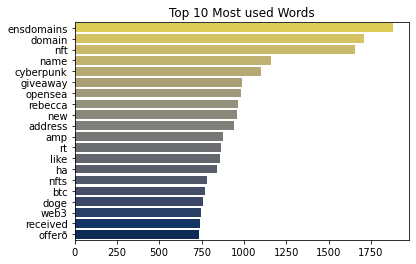

In [9]:
#plot most used words
sns.barplot(x=topvals,y=topkeys,palette="cividis_r").set(title='Top 10 Most used Words')

# Vectorizing Strings of Text

Strings of text must be converted to a matrix before they can be analyzed by machine learning algorithms. A Tfidf Vectorizer will be used to convert the stings of text in each document into a matrix so that they can be analyzed. A Tfidf vectorizer does this by assigning a weight for each word to the matrix based on the importance of that word to the document. The process of vectorizing the text is performed in the cell below.


In [10]:
#create TfidVectorizer to create the numerical values
vectorizer = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)

#numericalize the textFeatures
X_tfidf = vectorizer.fit_transform(tweet_df['clean_text'].values.astype('U'))

# K Means

K means is an unsupervised learning method that seeks to divide information into a specified (k) number of clusters that capture the variation in the dataset. The k means algorithm randomly picks locations in the latent space called centroids and measures the distance between the nearest datapoints and the centroids. It updates the position of the centroid to the mean of the distance of the datapoints and repeats the measurement and movement process until no significant updates can be made. This iterative process effectively groups data into clusters but can have variations based on the random initial position of the centroids.

The process of K means clustering has been performed to generate 3 clusters using the ENS tweet data. The code used to construct this portion of the notebook is taken from the sci-kit learn documentation and from the Lucas de Sa word cloud example.


In [11]:
#define and fit kmeans model, from sk-learn documentation

#define hyperparameters
num_clusters = 3
seed=3

#fit model
kmeans = KMeans(n_clusters=num_clusters,
                max_iter=100,
                n_init=1,
                random_state=seed,
                ).fit(X_tfidf)

# Top 10 Words per Cluster

In [12]:
#generate top 10 words per cluster, from scikitlearn

#arrange data for extraction of top words
original_space_centroids = kmeans.cluster_centers_
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

#generate lists of words for each cluster
print('\033[1m'+'The top ten words in each cluster are:'+'\033[0m')
print()
for i in range(num_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

The top ten words in each cluster are:

Cluster 0: domain registration ensdomains new nft name cyberpunk rt rebecca address 
Cluster 1: offerð received ens_domains__ 1î 16î 15î 13î 17î 12î 18î 
Cluster 2: usd web3names opensea bought weth ensnames ensemoji bid emoji ha 


# Cluster Wordclouds

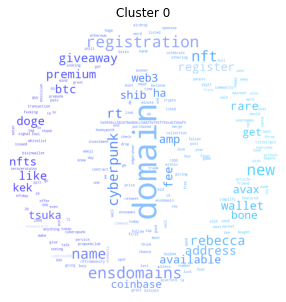

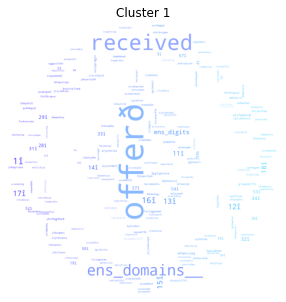

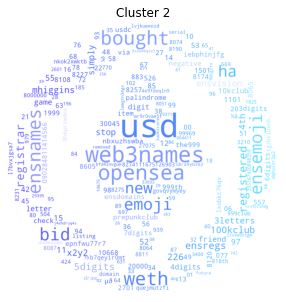

In [13]:
#Generate wordclouds for topic clusters, from Lucas de Sa
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = terms
generateWordClouds(centroids)

# K Mean 3 Discussion

Pulling the top ten words from a cluster, and visualizing those clusters in a word cloud, reveals themes occurring in the ENS tweet dataset. <br>

The first cluster contains references to the registration of Cyberpunk Edgerunners ENS domain names. Cyberpunk Edgerunners, an animated series based on Cyberpunk 2077, was released on Netflix the week this dataset was pulled and must be inspiring the registration of ENS domain names using themes from the show.<br>

The second cluster contains references to the offer and sale of ENS domain names containing a digit and the i hat (î) symbol. Some lucky ENS visionary must have scored a jackpot selling i hat digit domain names or is attempting to do so. <br>

The last cluster contains strong references to the registration of emoji ENS names and to opensea, a website that serves as a marketplace for NFT transactions.


# Optimal Clusters

For any dataset there is an optimal number of clusters that can be found that best represents the variation in the data. This optimal number can be estimated using a scree plot. A scree plot shows how much variation each additional cluster captures in the data. An ideal scree plot will form an elbow shape. The joint in the elbow represents the point at which additional clusters no longer capture additional variation. <br>

A scree plot can be constructed by brute force iterating through many k means models with different cluster counts. Those models are scored and the scores are appended to a list to form the plot.<br>

An np.diff comparison is also graphed alongside the scree plot. The np.diff function calculates the difference between subsequent points along the given axis.


In [14]:
# determine the optimal number of clusters, MSDS680

#create list to append scores
sum_sq= []

# fit the model for a range of 2 to 30 clusters and add to sum_sq[]
for n in range (2,30):
    print('Calculating for ',n,' clusters')
    
    # random_start makes the results reproducible 
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(X_tfidf)
    sum_sq.append(-model.score(X_tfidf))

Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters
Calculating for  11  clusters
Calculating for  12  clusters
Calculating for  13  clusters
Calculating for  14  clusters
Calculating for  15  clusters
Calculating for  16  clusters
Calculating for  17  clusters
Calculating for  18  clusters
Calculating for  19  clusters
Calculating for  20  clusters
Calculating for  21  clusters
Calculating for  22  clusters
Calculating for  23  clusters
Calculating for  24  clusters
Calculating for  25  clusters
Calculating for  26  clusters
Calculating for  27  clusters
Calculating for  28  clusters
Calculating for  29  clusters


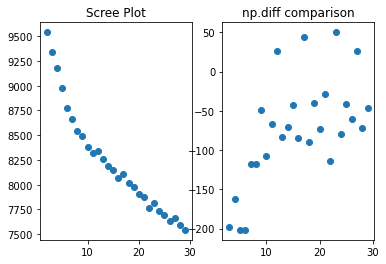

In [15]:
#plot validation and loss
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

#Scree Plot
ax1.set_title('Scree Plot')
ax1.scatter(range(2,30), sum_sq)

#np.diff()
ax2.set_title('np.diff comparison')
ax2.scatter(range(3, 30), np.diff(sum_sq))

# Optimal Clusters = 9

The scree plot begins to form an elbow around 9 clusters, at which point the slope of the line decreases. The np.diff plot also shows an elbow forming around 9 clusters, after 9 clusters a trend line drawn on the np.diff chart would flatten out. <br>

A new k means model will be generated using 9 clusters to capture the variation in the dataset.


In [16]:
#fit a K=9 means model

#define a few hyperparameters
num_clusters = 9
seed=3

#fit model
optimalkmeans = KMeans(n_clusters=num_clusters,
                max_iter=100,
                n_init=1,
                random_state=seed,
                ).fit(X_tfidf)

In [17]:
#show top 10 words in each cluster, sci-kit learn

#arrange data for extraction of top 10 words
original_space_centroids = optimalkmeans.cluster_centers_
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

#print top 10 words for each cluster
print('\033[1m'+'The top ten words in each cluster are:'+'\033[0m')
print()
for i in range(num_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

The top ten words in each cluster are:

Cluster 0: ensdomains domain opensea web3 sale nfts ensdomain nft offer ensvision 
Cluster 1: offerð received ens_domains__ 1î 16î 15î 13î 17î 12î 18î 
Cluster 2: usd web3names opensea weth ensemoji bid ensnames emoji bought ha 
Cluster 3: rare register premium fee available name 500 fallen ha 2000 
Cluster 4: usernames coinbase wallet simplify hand transaction crypto traditional bitcoin exchange 
Cluster 5: cyberpunk rebecca tsuka bone kek shib avax doge btc 0x0936cc58247b6d68cc5d42fe792f793cdcf44af5 
Cluster 6: registration new domain 1â 0â 016945 somethingcoming metað 5â 3â 
Cluster 7: rt giveaway amp drop follow like enter giving 100 celebrate 
Cluster 8: digit name get wa nft gm one bought market good 


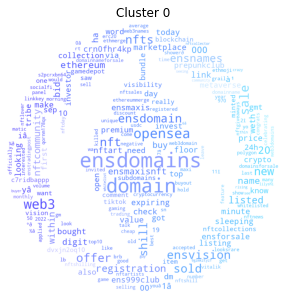

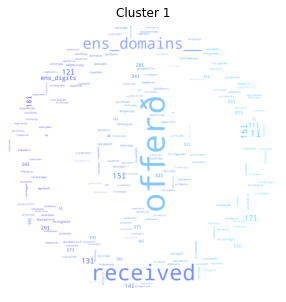

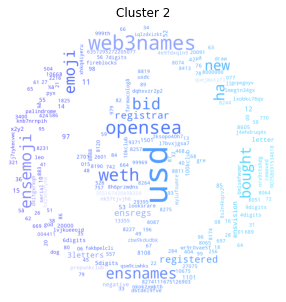

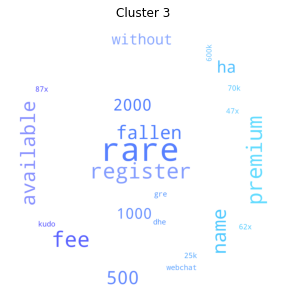

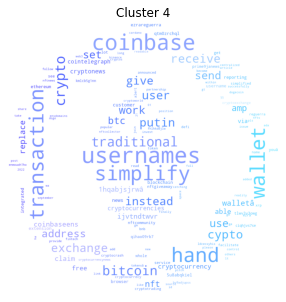

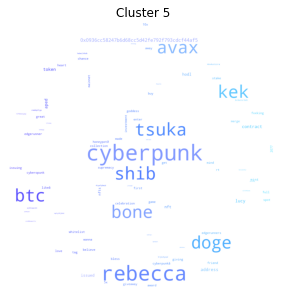

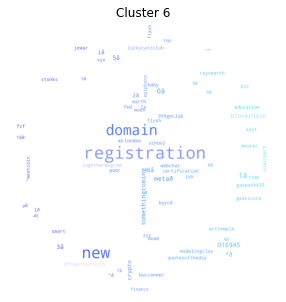

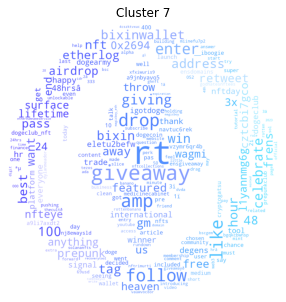

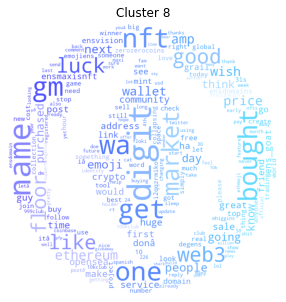

In [18]:
#generate wordclouds for each cluster, Lucas de Sa
centroids = pd.DataFrame(optimalkmeans.cluster_centers_)
centroids.columns = terms
generateWordClouds(centroids)

# K Mean 9 Discussion

The 9 word clouds demonstrate the effect of increasing the cluster size. This has separated some of the topics into distinct and sparse looking clusters. Topics that had previously been aggregated with other ideas, such as i hat names, are now separated into distinct clusters. <br>

There are distinct themes in the new clusters that have emerged, in addition to a cluster for i hat names, there is a cluster for a hat names. There are also clusters tied to giveaways "drops", and additional clusters for cryptocurrency service websites such as Coinbase.<br>


# Hierarchical Clustering

A second method for clustering data is hierarchical clustering. Hierarchical clustering assembles clusters by linking the two closest related data points together and then combining that cluster with an additional datapoint until all items in a dataset are connected.<br>

## Dendrograms

The best way to visualize hierarchical clustering is with a dendrogram, shown below for the ENS tweets dataset. A dendrogram visualizes the linkages between datapoints by showing where clusters merge with vertical and horizontal lines. Dendrograms are also used for determining an interesting number of clusters to represent variation in the dataset. A horizontal line can be drawn across the dendrogram using the highest vertical line that does not intersect any horizontal lines. The number of vertical lines this guideline crosses is the optimal number of clusters for the dataset. For the ENS tweets dataset, an interesting number of clusters would be 7, as illustrated in the graph below.


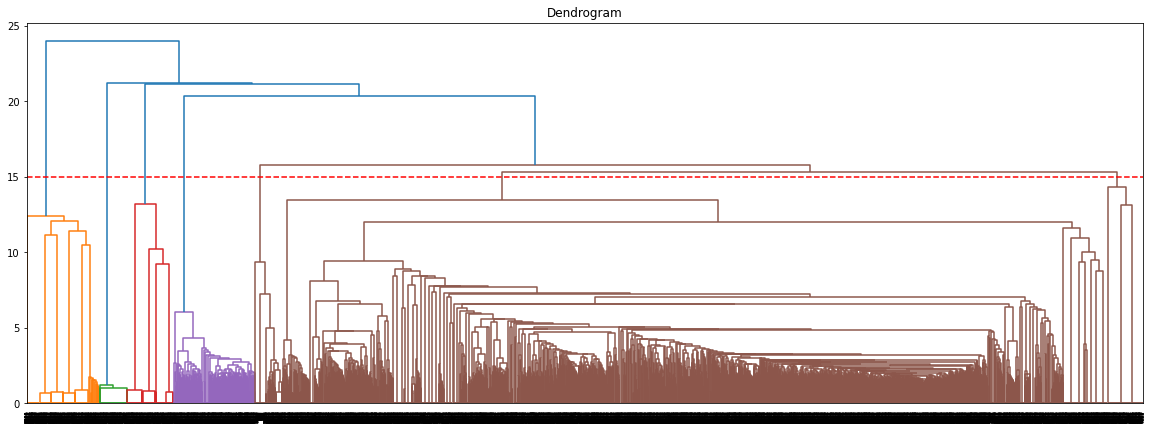

In [19]:
#plot dendrogram, MSDS680
plt.figure(figsize=(20, 7))  
plt.title("Dendrogram")  
dend = sch.dendrogram(sch.linkage(X_tfidf.toarray(), method='ward'))
plt.axhline(y=15, color='r', linestyle='--')

In [20]:
# perfrom clustering, extract data labels, MSDS680

#define a clustering model
heircluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  

#extract cluster labels
clusterlabels = heircluster.fit_predict(X_tfidf.toarray())

# Top 10 Words by Heirarchical Cluster

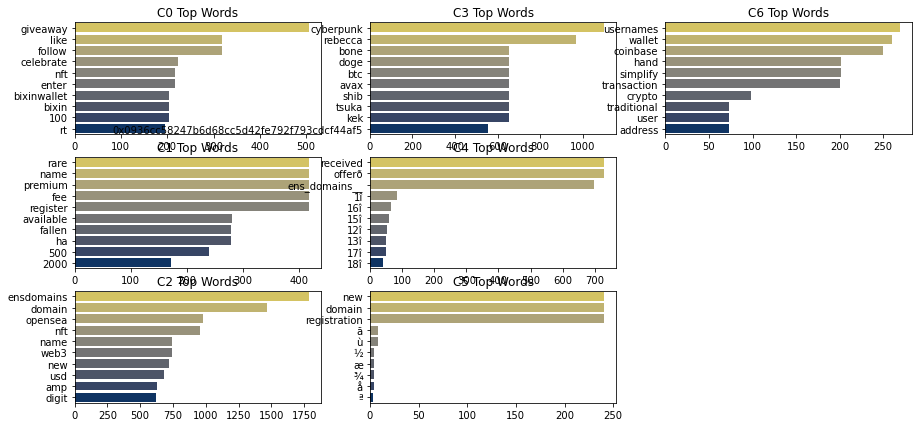

In [21]:
#append cluster labels to DF
tweet_df['clusterlabels'] = clusterlabels

#filter for clusters
c0_df = tweet_df[tweet_df['clusterlabels']==0]
c1_df = tweet_df[tweet_df['clusterlabels']==1]
c2_df = tweet_df[tweet_df['clusterlabels']==2]
c3_df = tweet_df[tweet_df['clusterlabels']==3]
c4_df = tweet_df[tweet_df['clusterlabels']==4]
c5_df = tweet_df[tweet_df['clusterlabels']==5]
c6_df = tweet_df[tweet_df['clusterlabels']==6]

#Create frequency series for visualization
c0freq = pd.Series(' '.join(c0_df.clean_text).split()).value_counts().to_dict()
c1freq = pd.Series(' '.join(c1_df.clean_text).split()).value_counts().to_dict()
c2freq = pd.Series(' '.join(c2_df.clean_text).split()).value_counts().to_dict()
c3freq = pd.Series(' '.join(c3_df.clean_text).split()).value_counts().to_dict()
c4freq = pd.Series(' '.join(c4_df.clean_text).split()).value_counts().to_dict()
c5freq = pd.Series(' '.join(c5_df.clean_text).split()).value_counts().to_dict()
c6freq = pd.Series(' '.join(c6_df.clean_text).split()).value_counts().to_dict()

#create keys for visualization
c0topkeys = list(c0freq .keys())[:10]
c1topkeys = list(c1freq .keys())[:10]
c2topkeys = list(c2freq .keys())[:10]
c3topkeys = list(c3freq .keys())[:10]
c4topkeys = list(c4freq .keys())[:10]
c5topkeys = list(c5freq .keys())[:10]
c6topkeys = list(c6freq .keys())[:10]

#create values for visualization
c0topvals = list(c0freq.values())[:10]
c1topvals = list(c1freq.values())[:10]
c2topvals = list(c2freq.values())[:10]
c3topvals = list(c3freq.values())[:10]
c4topvals = list(c4freq.values())[:10]
c5topvals = list(c5freq.values())[:10]
c6topvals = list(c6freq.values())[:10]

#plot most used words
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
sns.barplot(x=c0topvals,y=c0topkeys,palette="cividis_r", ax=axs[0,0]).set(title='C0 Top Words')
sns.barplot(x=c1topvals,y=c1topkeys,palette="cividis_r", ax=axs[1,0]).set(title='C1 Top Words')
sns.barplot(x=c2topvals,y=c2topkeys,palette="cividis_r", ax=axs[2,0]).set(title='C2 Top Words')
sns.barplot(x=c3topvals,y=c3topkeys,palette="cividis_r", ax=axs[0,1]).set(title='C3 Top Words')
sns.barplot(x=c4topvals,y=c4topkeys,palette="cividis_r", ax=axs[1,1]).set(title='C4 Top Words')
sns.barplot(x=c5topvals,y=c5topkeys,palette="cividis_r", ax=axs[2,1]).set(title='C5 Top Words')
sns.barplot(x=c6topvals,y=c6topkeys,palette="cividis_r", ax=axs[0,2]).set(title='C6 Top Words')
axs[1,2].set_axis_off()
axs[2,2].set_axis_off()

# Investigate Clusters 4 and 5

Clusters 4 and 5 show unusual frequency patterns. Three words are used several hundred times and linked to a few unique characters. Further exploration shows that these clusters are caused by robots that use the same words in every tweet. These robots announce offers or registrations for ENS domain names.


In [22]:
c4_df.head()

,clean_text,clusterlabels
321,² received offerð ens_domains__ 5î qdu9x2jixe,4
322,³ received offerð ens_domains__ 01î 52dspz5z3l,4
323,received offerð ens_domains__ 5î jmzewxeg6b,4
324,received offerð ens_domains__ 5î maabrhankx,4
325,¾ received offerð ens_domains__ 01î irhrs56yk9,4


In [23]:
c5_df.head()

,clean_text,clusterlabels
3,new domain registration yellowspoon sandelis,5
40,new domain registration craftedlegal dccninech...,5
81,new domain registration thirdplacebarroom ydy,5
120,new domain registration fanbelt badkidclub,5
161,new domain registration raguz,5


# Wordclouds by Heirarchical Cluster

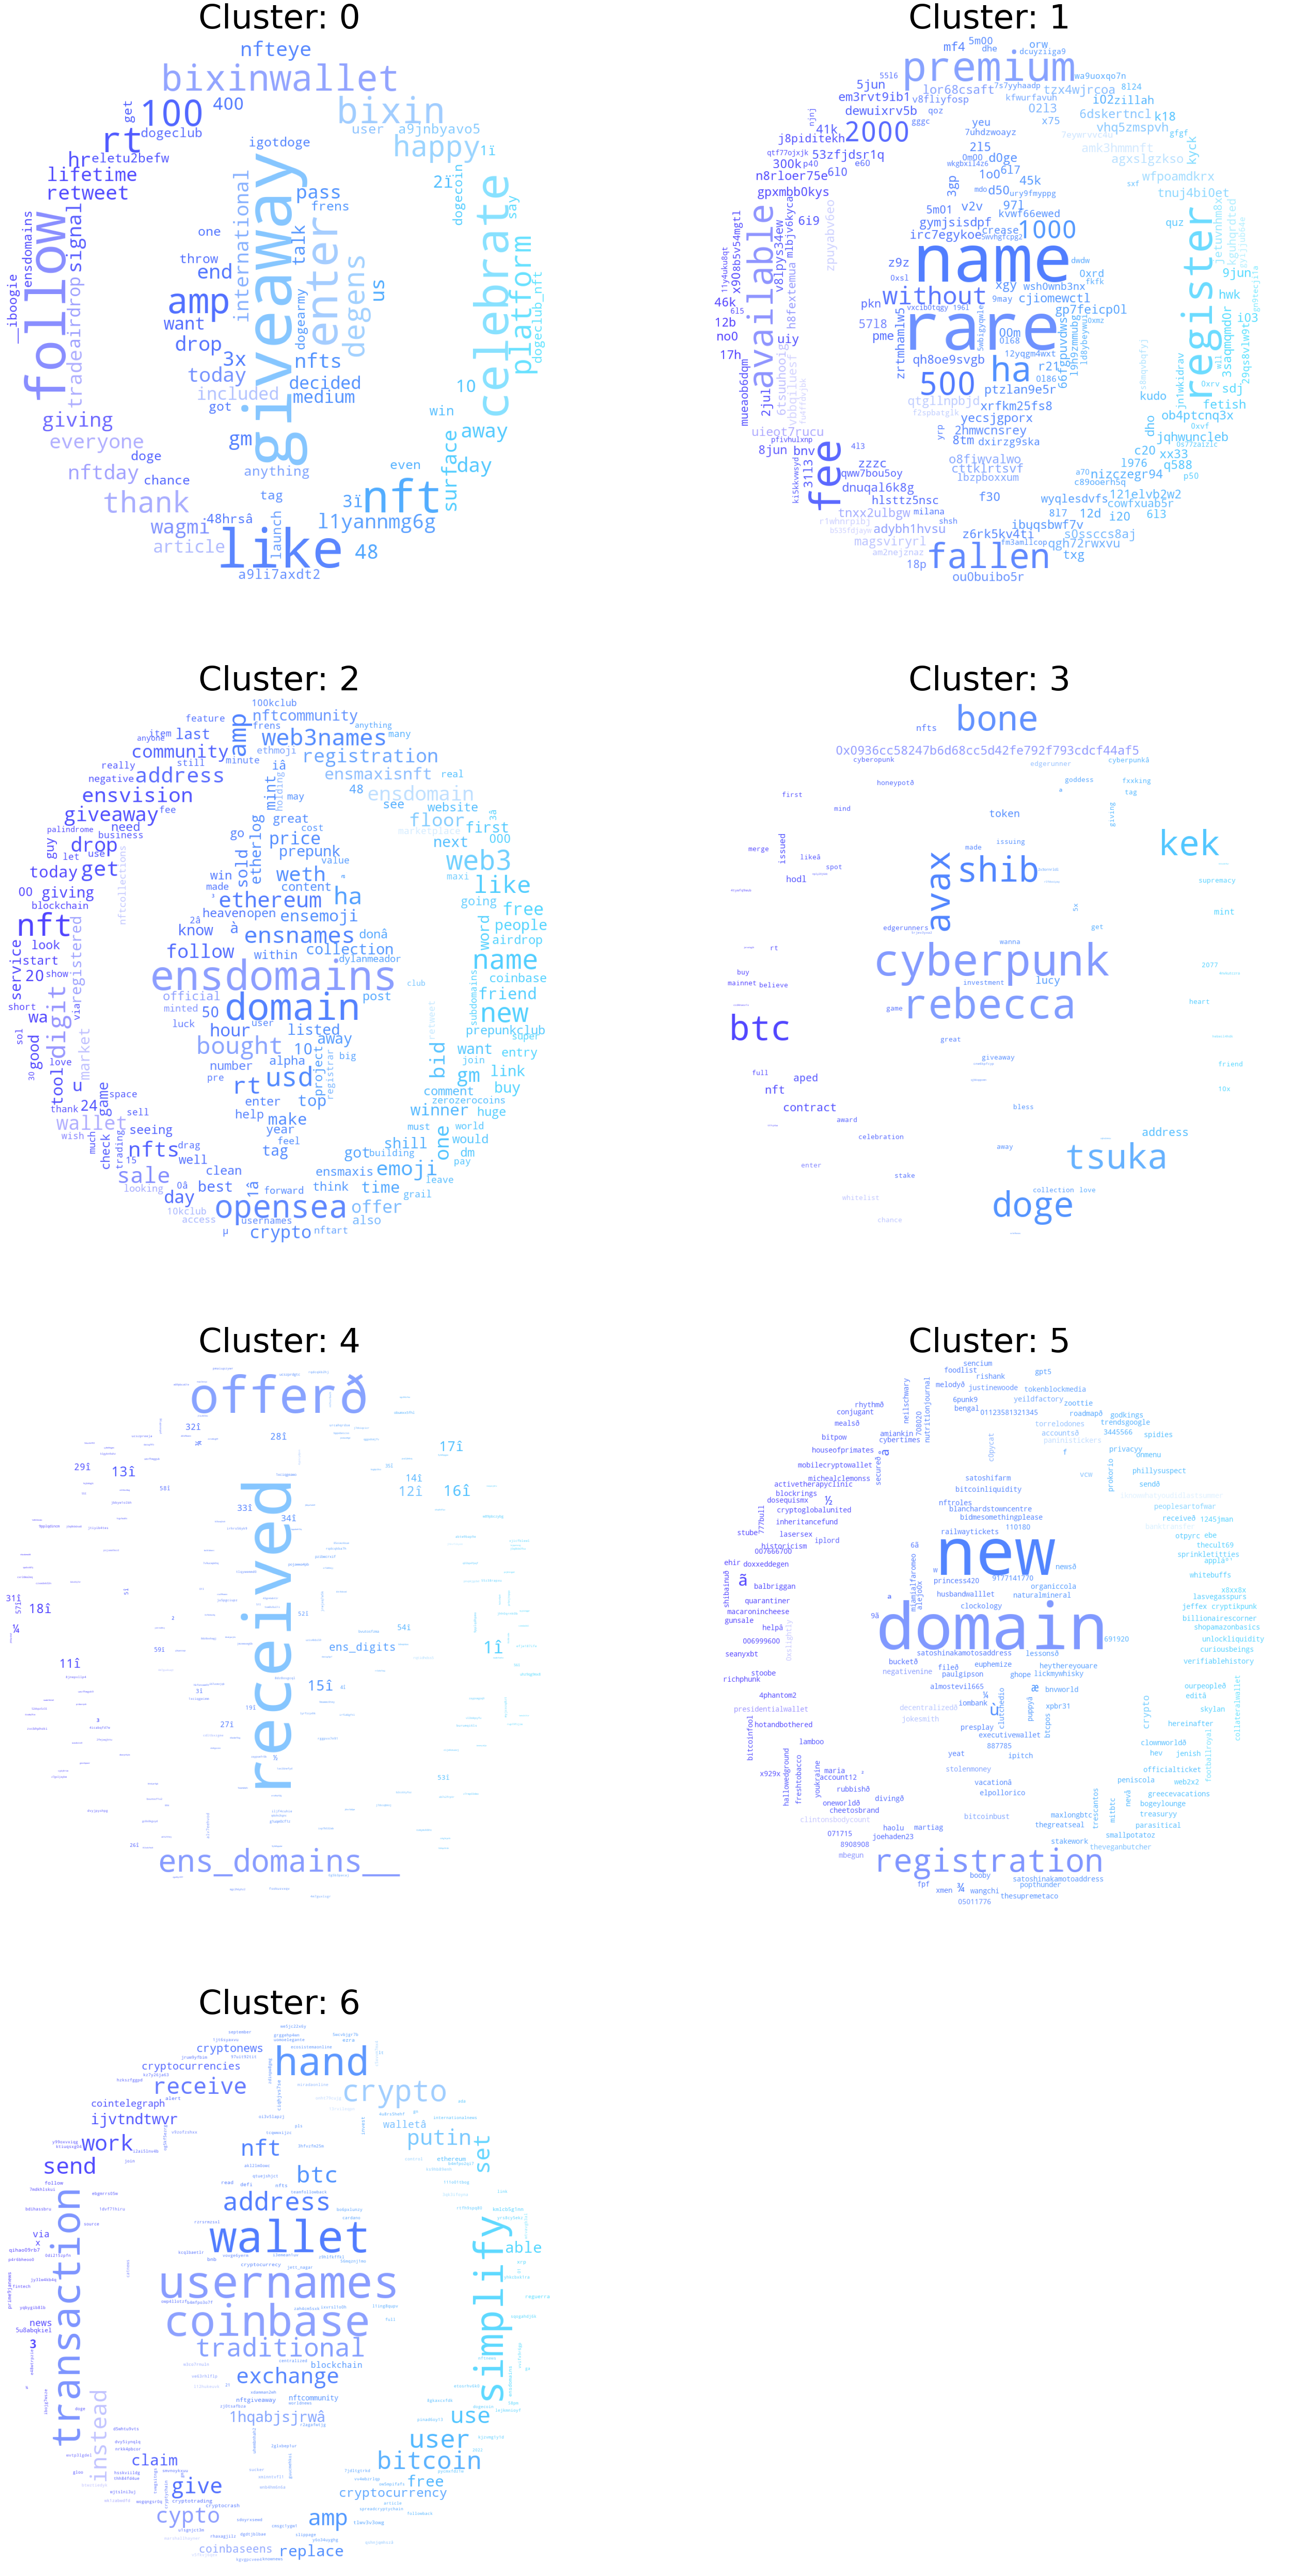

In [24]:
wordcloud = WordCloud(max_font_size=128, background_color = 'white',mask=mask_coloring)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(50,100))

wordcloud.generate_from_frequencies(c0freq)
ax[0,0].imshow(wordcloud.recolor(color_func=image_colors))
ax[0,0].set_title('Cluster: 0', fontsize=72)

wordcloud.generate_from_frequencies(c1freq)
ax[0,1].imshow(wordcloud.recolor(color_func=image_colors))
ax[0,1].set_title('Cluster: 1', fontsize=72)

wordcloud.generate_from_frequencies(c2freq)
ax[1,0].imshow(wordcloud.recolor(color_func=image_colors))
ax[1,0].set_title('Cluster: 2', fontsize=72)

wordcloud.generate_from_frequencies(c3freq)
ax[1,1].imshow(wordcloud.recolor(color_func=image_colors))
ax[1,1].set_title('Cluster: 3', fontsize=72)

wordcloud.generate_from_frequencies(c4freq)
ax[2,0].imshow(wordcloud.recolor(color_func=image_colors))
ax[2,0].set_title('Cluster: 4', fontsize=72)

wordcloud.generate_from_frequencies(c5freq)
ax[2,1].imshow(wordcloud.recolor(color_func=image_colors))
ax[2,1].set_title('Cluster: 5', fontsize=72)

wordcloud.generate_from_frequencies(c6freq)
ax[3,0].imshow(wordcloud.recolor(color_func=image_colors))
ax[3,0].set_title('Cluster: 6', fontsize=72)

#Turn off axis
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[1,0].set_axis_off()
ax[1,1].set_axis_off()
ax[2,0].set_axis_off()
ax[2,1].set_axis_off()
ax[3,0].set_axis_off()
ax[3,1].set_axis_off()

# Hierarchical Clustering Discussion

The clusters formed by agglomerative clustering are similar to the clusters produced by the k means algorithm. There are clusters for Cyberpunk Edgerunners, i hat names, and a few linked to service websites like opensea and Coinbase. The strength of the relationships in these clusters makes them emerge regardless of the clustering method used to analyze the database.

The filtering and graphing technique employed on the agglomerative clustering data shows some interesting trends in clusters 4 and 5. These clusters come from bots that the same words repeatedly in their script. Increasing the number of clusters may lead to the identification of specific users who speak in a consistent fashion.

# Conclusion

Most of the topics revealed by clustering analysis of #ENS tweets seem similar. This is likely a result of the underlying #ENS tweet data having a narrow focus. A wider reaching hashtag, such as #art, might have separated into a broader range of topic clusters. While the topics were narrow, the analysis did reveal interesting trends occurring in the hashtag cloud. Some are tied to recent events in culture, such as the debut of the show Cyberpunk Edgerunners. Others are linked to institutions in cryptocurrency, like Coinbase and opensea. Clustering even revealed the effect of robots who have the power to develop their own clusters in the dataset by using the same words in each tweet This exercise demonstrates the power clustering algorithms have to derive meaning from unlabeled datasets.


# References

This notebook was created using a blend of techniques from Regis's MSDS600, MSDS680, and MSDS650 coursework. In addition to this, the reference literature for sci-kit learn, pandas, and seaborn was consulted to construct the code. Code examples were also taken and reworked from several web sources cited below. 

Mueller, Adreas. (2020). <i> Wordcloud for Python </i>.from amueller.github.io

Pandas Development Team. 2021. <i>Python API reference</i>.from pandas.pydata.org.https://pandas.pydata.org/docs/reference/index.html

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. <i> Journal of Machine Learning Research 12,</i> 2825-2830

Sa, Lucas de. (2019). <i> Text Clustering with K-Means </i> medium. retreived 9/24/2022 from https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b

Waskom ML (2021). seaborn: statistical data visualization. <i> Journal of Open Source Software 6</i>(60): 3021.a